# Importing the data from kagle to colab


In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abdelrhmansadek","key":"b4d08023cfd39697f497f478baf1caef"}'}

In [2]:
! pip install -q kaggle

In [3]:
! mkdir ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! cp kaggle.json ~/.kaggle/

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
! kaggle datasets list

ref                                                       title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ruchi798/data-science-job-salaries                        Data Science Job Salaries                           7KB  2022-06-15 08:59:12           8645        279  1.0              
surajjha101/bigbasket-entire-product-list-28k-datapoints  BigBasket Entire Product List (~28K datapoints)     6MB  2022-06-22 12:51:18           3033        116  1.0              
zusmani/petrolgas-prices-worldwide                        Petrol/Gas Prices Worldwide                        10KB  2022-06-24 01:25:33           2615        122  1.0              
ramjasmaurya/1-gb-internet-price                          Internet Prices around 200+ countries in 2

In [5]:
! mkdir face-mask-detection-dataset

In [6]:
!kaggle datasets download -d wobotintelligence/face-mask-detection-dataset

 99% 2.46G/2.50G [00:16<00:00, 131MB/s]
100% 2.50G/2.50G [00:16<00:00, 165MB/s]


In [7]:
! unzip face-mask-detection-dataset.zip -d face-mask-detection-dataset

Streaming output truncated to the last 5000 lines.
  inflating: face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/1091.jpg  
  inflating: face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/1092.jpg  
  inflating: face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/1093.jpg  
  inflating: face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/1094.jpg  
  inflating: face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/1095.jpg  
  inflating: face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/1096.jpg  
  inflating: face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/1097.jpg  
  inflating: face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/1098.jpg  
  inflating: face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images/1099.jpg  
  inflating: face-mask-detection-dataset/Medical mask/Medical mask/

In [8]:
! kaggle datasets download -d sambitmukherjee/caffe-face-detector-opencv-pretrained-model

 52% 5.00M/9.57M [00:00<00:00, 49.1MB/s]
100% 9.57M/9.57M [00:00<00:00, 69.9MB/s]


In [9]:
! unzip caffe-face-detector-opencv-pretrained-model.zip -d face-mask-detection-dataset

Archive:  caffe-face-detector-opencv-pretrained-model.zip
  inflating: face-mask-detection-dataset/architecture.txt  
  inflating: face-mask-detection-dataset/weights.caffemodel  


now as the data has been imported from kagle lets import the necessary libraries to work on ower model

# Importing libraries

In [2]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers


for dirname, subfolders, filenames in os.walk("../input/"):
    for subf in subfolders:
        print(os.path.join(dirname, subf))

Now we read our data

In [3]:
directory = "/content/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations"
image_directory = "/content/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images"

df = pd.read_csv("/content/face-mask-detection-dataset/train.csv")
df_test = pd.read_csv("/content/face-mask-detection-dataset/submission.csv")



importing the pre trained model

In [4]:
cvNet = cv2.dnn.readNetFromCaffe('/content/face-mask-detection-dataset/architecture.txt',
                                 '/content/face-mask-detection-dataset/weights.caffemodel')

In [5]:
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [6]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

{'Annotations': [{'Attributes': {},
   'BoundingBox': [621, 79, 755, 240],
   'Confidence': 1,
   'ID': 531048205352773504,
   'classname': 'face_with_mask',
   'isProtected': False},
  {'Attributes': {},
   'BoundingBox': [632, 140, 712, 224],
   'Confidence': 1,
   'ID': 274465162508878304,
   'classname': 'mask_surgical',
   'isProtected': False}],
 'FileName': '2091.jpg',
 'NumOfAnno': 2}

as we see the json file have the BoundingBox and Annotations of each image

In [7]:
df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [8]:
df['classname'].unique()

array(['face_with_mask', 'mask_colorful', 'face_no_mask',
       'face_with_mask_incorrect', 'mask_surgical', 'face_other_covering',
       'scarf_bandana', 'eyeglasses', 'helmet', 'face_shield',
       'sunglasses', 'hood', 'hat', 'goggles', 'hair_net', 'hijab_niqab',
       'other', 'gas_mask', 'balaclava_ski_mask', 'turban'], dtype=object)

the data have many classes in it but we will take only the classes {face_with_mask,face_no_mask} as our project requiers 


# reading the data 


In [9]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            data.append([img,labels["without mask"]])
random.shuffle(data)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


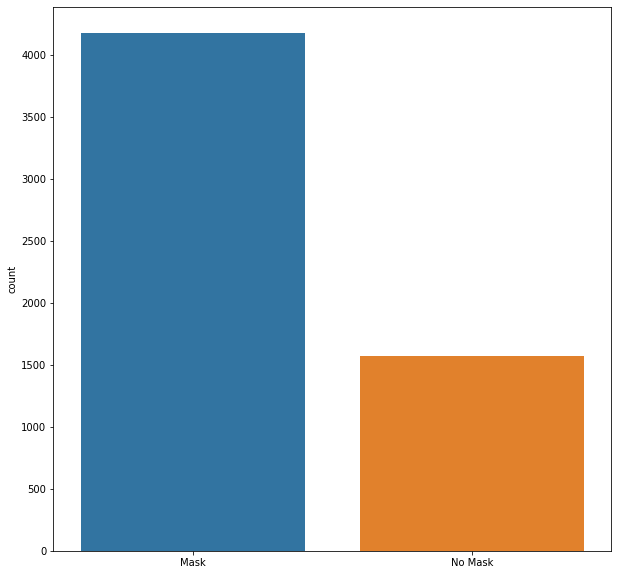

In [10]:
plt.figure(figsize=(10,10))
p = []
for face in data:
    if(face[1] == 0):
        p.append("Mask")
    else:
        p.append("No Mask")
sns.countplot(p)

as we can see the data is imbalance because the number of the masked imgaes is alot more than the non_masked image but we are using a pretained model so that wont be a proplem
 

In [11]:
len(data)

5749

# separate features and labels

In [12]:
X = []
y = []
for features,label in data:
    X.append(features)
    y.append(label)

X = np.array(X)/255.0
y = np.array(y)

In [13]:
X.shape , y.shape

((5749, 124, 124, 3), (5749,))

In [14]:
pd.Series(y).unique()

array([0, 1])

# spliting the data 

In [15]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=9,shuffle=True)

In [18]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(X_train)

In [37]:
model = keras.Sequential()

model.add(layers.Conv2D(32, (3,3), padding='same',activation=tf.nn.relu, input_shape=(124,124,3)))
model.add(layers.Conv2D(64, (3,3), activation=("relu")))
model.add(layers.Conv2D(128, (3,3), activation=("relu")))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(50, activation=("relu")))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='sigmoid'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 124, 124, 32)      896       
                                                                 
 conv2d_4 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 120, 120, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 60, 128)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 60, 60, 128)       0         
                                                                 
 flatten_1 (Flatten)         (None, 460800)            0         
                                                      

In [38]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam' ,metrics=['accuracy'])

In [39]:
history=model.fit(X_train, y_train, epochs=20,batch_size=64,verbose=1,validation_data=(X_test, y_test))

Epoch 1/20
72/72 [==============================] - 15s 194ms/step - loss: 0.7381 - accuracy: 0.7056 - val_loss: 0.2960 - val_accuracy: 0.8652
Epoch 2/20
72/72 [==============================] - 13s 188ms/step - loss: 0.3909 - accuracy: 0.8317 - val_loss: 0.2771 - val_accuracy: 0.8948
Epoch 3/20
72/72 [==============================] - 14s 188ms/step - loss: 0.3583 - accuracy: 0.8495 - val_loss: 0.2178 - val_accuracy: 0.9148
Epoch 4/20
72/72 [==============================] - 14s 189ms/step - loss: 0.3595 - accuracy: 0.8402 - val_loss: 0.2308 - val_accuracy: 0.9165
Epoch 5/20
72/72 [==============================] - 14s 190ms/step - loss: 0.3164 - accuracy: 0.8711 - val_loss: 0.1894 - val_accuracy: 0.9217
Epoch 6/20
72/72 [==============================] - 14s 191ms/step - loss: 0.3059 - accuracy: 0.8698 - val_loss: 0.2432 - val_accuracy: 0.8626
Epoch 7/20
72/72 [==============================] - 14s 192ms/step - loss: 0.2971 - accuracy: 0.8774 - val_loss: 0.2116 - val_accuracy: 0.9287

In [40]:
model.evaluate(X_test, y_test)

36/36 [==============================] - 1s 34ms/step - loss: 0.2709 - accuracy: 0.9322


[0.27086377143859863, 0.9321739077568054]

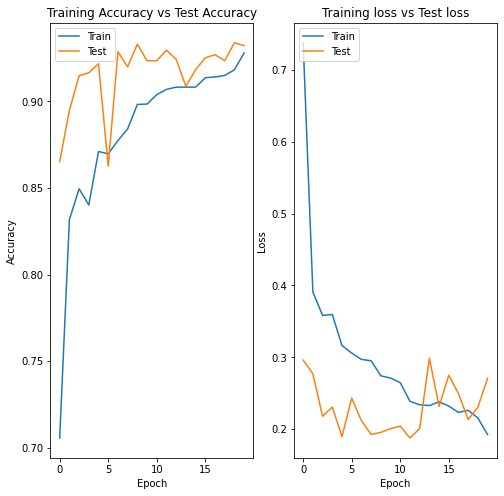

In [42]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],)
plt.plot(history.history['val_accuracy'],)
plt.title('Training Accuracy vs Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


plt.subplot(1,2,2)
plt.plot(history.history['loss'],)
plt.plot(history.history['val_loss'],)
plt.title('Training loss vs Test loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


In [43]:
from google.colab import files
files.upload()

{}

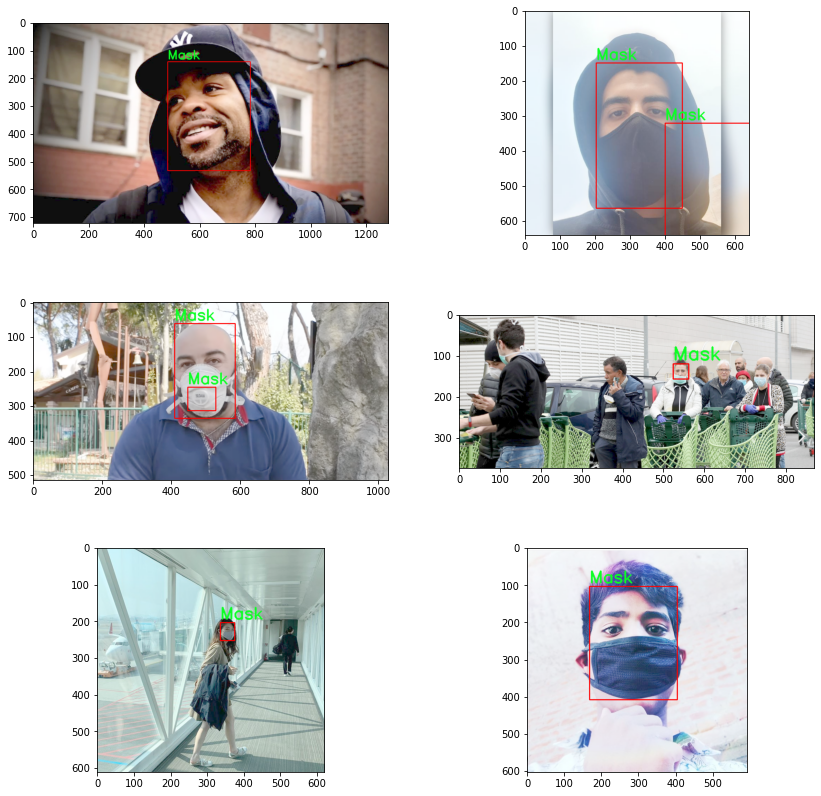

In [44]:
test_images = ['0001.jpg','171726225_581055039747217_2376785759929807368_n.jpg', '4501.png','3939.png','3769.png','3991.png']

gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            sureness = detections[0, 0, i, 2]
            if sureness > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                predictions = model.predict(im)
                result=np.argmax(predictions)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] ,(startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 3)
                
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()